In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import seaborn as sns
import networkx as nx
from scipy import stats
import matplotlib.colors as mcolors

In [2]:
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

# Eurovision Song Contest (ESC) Analysis

## Data Familiarization

In [3]:
# Get current directory
cwd = os.getcwd()
print(cwd)

c:\Users\mate1\OneDrive\Escritorio\Repository\Eurovision_Contest_Analysis


In [4]:
# Load data
df_votes = pd.read_csv('Data/votes.csv')
df_votes.head()

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,at,nl,6,NaN,NaN
1,1957,final,at,fr,at,fr,0,NaN,NaN
2,1957,final,at,dk,at,dk,0,NaN,NaN
3,1957,final,at,lu,at,lu,3,NaN,NaN
4,1957,final,at,de,at,de,0,NaN,NaN


In [5]:
# Get the initial and last years of the data
initial_year = df_votes['year'].min()
final_year = df_votes['year'].max()
print('Initial year:', initial_year)
print('Final year:', final_year)

Initial year: 1957
Final year: 2023


### Data Cleaning

In this work we are only interested in the final round.

In [6]:
# Get only the final round
df_final_round = df_votes[df_votes['round'] == 'final']

In [7]:
# # Remove giving 0 points
# df_final_round = df_final_round[df_final_round['total_points'] > 0]
# df_final_round

In [8]:
# Get the total number of countries
total_countries = df_final_round['from_country_id']
total_countries = np.array(total_countries)
total_countries = np.unique(total_countries)
print('Total countries:', total_countries)
print('Number of countries:', len(total_countries))

Total countries: ['ad' 'al' 'am' 'at' 'au' 'az' 'ba' 'be' 'bg' 'by' 'ch' 'cs' 'cy' 'cz'
 'de' 'dk' 'ee' 'es' 'fi' 'fr' 'gb' 'ge' 'gr' 'hr' 'hu' 'ie' 'il' 'is'
 'it' 'lt' 'lu' 'lv' 'ma' 'mc' 'md' 'me' 'mk' 'mt' 'nl' 'no' 'pl' 'pt'
 'ro' 'rs' 'ru' 'se' 'si' 'sk' 'sm' 'tr' 'ua' 'wld' 'yu']
Number of countries: 53


In [9]:
# # Broadcast the Yugoslavia points to their actual countries
# broadcast = {
#     'yu': ['ba', 'hr', 'mk', 'rs', 'si'],
#     'cs': ['rs', 'me']
# }

# df_final_round['from_country_id'] = df_final_round['from_country_id'].apply(lambda x: broadcast[x] if x in broadcast.keys() else x)
# df_final_round['to_country_id'] = df_final_round['to_country_id'].apply(lambda x: broadcast[x] if x in broadcast.keys() else x)
# df_final_round.explode('from_country_id').explode('to_country_id')

In [10]:
# Dictionary with the real name of the countries
country_id_to_name = {
    'ad': 'Andorra',
    'al': 'Albania',
    'am': 'Armenia',
    'at': 'Austria',
    'au': 'Australia',
    'az': 'Azerbaijan',
    'ba': 'Bosnia',
    'be': 'Belgium',
    'bg': 'Bulgaria',
    'by': 'Belarus',
    'ch': 'Switzerland',
    'cs': 'Serbia and Montenegro',  # Historical ID
    'cy': 'Cyprus',
    'cz': 'Czech Republic',
    'de': 'Germany',
    'dk': 'Denmark',
    'ee': 'Estonia',
    'es': 'Spain',
    'fi': 'Finland',
    'fr': 'France',
    'gb': 'UK',
    'ge': 'Georgia',
    'gr': 'Greece',
    'hr': 'Croatia',
    'hu': 'Hungary',
    'ie': 'Ireland',
    'il': 'Israel',
    'is': 'Iceland',
    'it': 'Italy',
    'lt': 'Lithuania',
    'lu': 'Luxembourg',
    'lv': 'Latvia',
    'ma': 'Morocco',
    'mc': 'Monaco',
    'md': 'Moldova',
    'me': 'Montenegro',
    'mk': 'N. Macedonia',
    'mt': 'Malta',
    'nl': 'Netherlands',
    'no': 'Norway',
    'pl': 'Poland',
    'pt': 'Portugal',
    'ro': 'Romania',
    'rs': 'Serbia',
    'ru': 'Russia',
    'se': 'Sweden',
    'si': 'Slovenia',
    'sk': 'Slovakia',
    'sm': 'San Marino',
    'tr': 'Turkey',
    'ua': 'Ukraine',
    'wld': 'World',  # Possible placeholder for aggregated data
    'yu': 'Yugoslavia'  # Historical ID
}

In [11]:
df_final_round['from_country'] = df_final_round['from_country'].map(country_id_to_name)
df_final_round['to_country'] = df_final_round['to_country'].map(country_id_to_name)
df_final_round

C:\Users\mate1\AppData\Local\Temp\ipykernel_4560\1287897805.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_round['from_country'] = df_final_round['from_country'].map(country_id_to_name)
C:\Users\mate1\AppData\Local\Temp\ipykernel_4560\1287897805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_round['to_country'] = df_final_round['to_country'].map(country_id_to_name)


,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,Austria,Netherlands,6,NaN,NaN
1,1957,final,at,fr,Austria,France,0,NaN,NaN
2,1957,final,at,dk,Austria,Denmark,0,NaN,NaN
3,1957,final,at,lu,Austria,Luxembourg,3,NaN,NaN
4,1957,final,at,de,Austria,Germany,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
51349,2023,final,wld,al,World,Albania,6,6.0,NaN
51350,2023,final,wld,pt,World,Portugal,0,0.0,NaN
51351,2023,final,wld,rs,World,Serbia,0,0.0,NaN
51352,2023,final,wld,gb,World,UK,0,0.0,NaN


### Number of Participations

In [12]:
def participation_counts_f(df, initial_year, final_year):
    
    # Get the number of participations of each country
    df = df[(df['year'] >= initial_year) & (df['year'] <= final_year)]

    # Combine all country IDs into a single column with the corresponding year
    participations = pd.concat([
        df[['year', 'from_country']].rename(columns={'from_country': 'country'}),
        df[['year', 'to_country']].rename(columns={'to_country': 'country'}),
    ])

    # Explode the lists into individual rows
    participations = participations.explode('country')

    # Drop duplicates to ensure each country-year combination is only counted once
    participations = participations.drop_duplicates()

    # Count the number of unique years each country participated
    participation_counts = participations.groupby('country')['year'].nunique()

    # Convert the result to a DataFrame
    participation_counts = participation_counts.reset_index()
    participation_counts.columns = ['country', 'participation_count']
    
    return participation_counts

In [13]:
# Get the number of participations of each country

participation_counts = participation_counts_f(df_final_round, initial_year, final_year)

# Represent in a table the number of participations of each country with their complete name
participation_counts = participation_counts.sort_values('participation_count', ascending=False)
participation_counts[['country', 'participation_count']]


,country,participation_count
18,Germany,65
49,UK,65
16,France,64
7,Belgium,63
34,Netherlands,62
45,Spain,62
46,Sweden,62
47,Switzerland,62
35,Norway,61
15,Finland,56


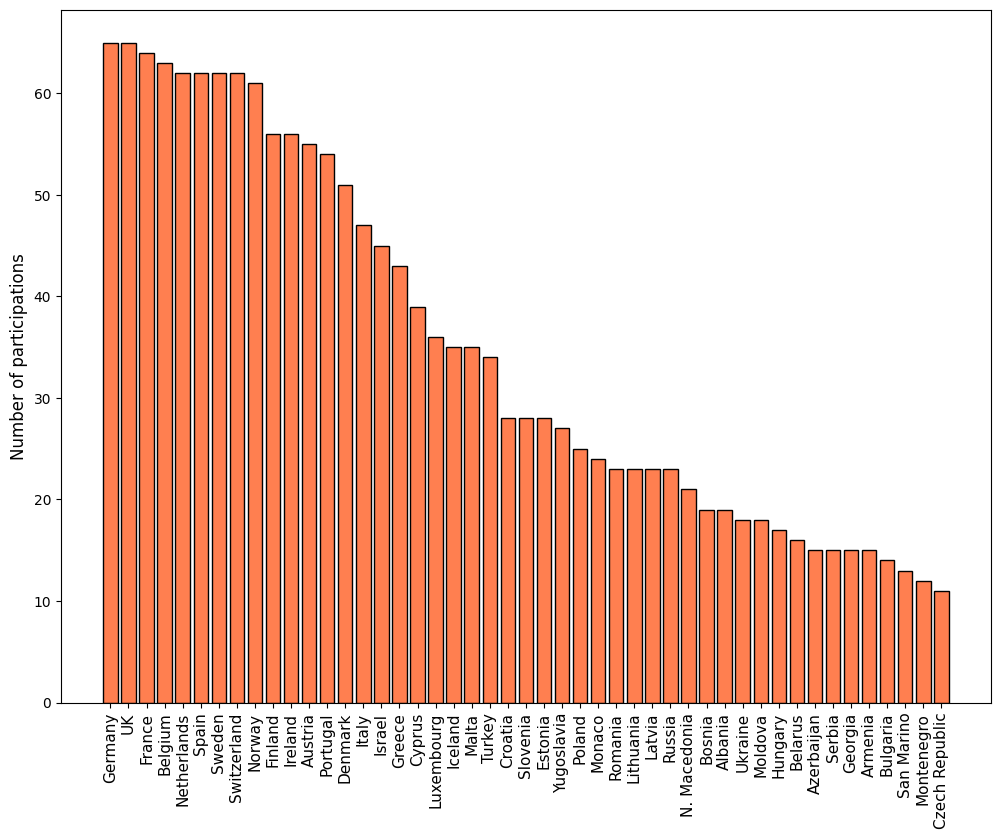

In [14]:
# Plot the number of participations of each country with a minimum of 10 participations
x = participation_counts[participation_counts['participation_count'] >= 10]

plt.figure(figsize=(12, 9))
plt.bar(x['country'], x['participation_count'], color='coral', edgecolor='k')
plt.xticks(rotation=90, fontsize=11)    
plt.ylabel('Number of participations', fontsize=12)
# plt.title('Number of participations of each country')
plt.savefig('Images/Number_of_participations_of_each_country.png')
plt.show()

In [15]:
countries = np.array(participation_counts['country'])
print('Countries:', countries)
print('Number of countries:', len(countries))

Countries: ['Germany' 'UK' 'France' 'Belgium' 'Netherlands' 'Spain' 'Sweden'
 'Switzerland' 'Norway' 'Finland' 'Ireland' 'Austria' 'Portugal' 'Denmark'
 'Italy' 'Israel' 'Greece' 'Cyprus' 'Luxembourg' 'Iceland' 'Malta'
 'Turkey' 'Croatia' 'Slovenia' 'Estonia' 'Yugoslavia' 'Poland' 'Monaco'
 'Romania' 'Lithuania' 'Latvia' 'Russia' 'N. Macedonia' 'Bosnia' 'Albania'
 'Ukraine' 'Moldova' 'Hungary' 'Belarus' 'Azerbaijan' 'Serbia' 'Georgia'
 'Armenia' 'Bulgaria' 'San Marino' 'Montenegro' 'Czech Republic'
 'Australia' 'Slovakia' 'Andorra' 'Serbia and Montenegro' 'Morocco'
 'World']
Number of countries: 53


### Number of wins

In [16]:
win_table = []
# Get the number of wins of each country by adding the points per year
for year in range(initial_year, final_year + 1):
    
    if year ==2020:
        # No eurovision in 2020
        continue
    df_year = df_final_round[df_final_round['year'] == year]
    table = df_year.groupby('to_country')['total_points'].sum().sort_values(ascending=False)

    if year == 1969:
        # The winner of 1969 was France, Spain, the United Kingdom and the Netherlands (all of the considered winners)
        winners = ['France', 'Spain', 'United Kingdom', 'Netherlands']
    elif year == 1991:
        # The winner was Sweden which draws with France
        winner = table.index[1]
    else:
        winner = table.index[0]
    points = table.iloc[0]
    win_table.append(winner)
    if winner=='Sweden':
        print(year, winner, points)
    

# Convert the result to a DataFrame
win_table = pd.DataFrame(win_table, columns=['country'])
win_table = win_table['country'].value_counts().reset_index()
win_table.columns = ['country', 'win_count']

1974 Sweden 24
1984 Sweden 145
1991 Sweden 146
1999 Sweden 163
2012 Sweden 372
2015 Sweden 365
2023 Sweden 583


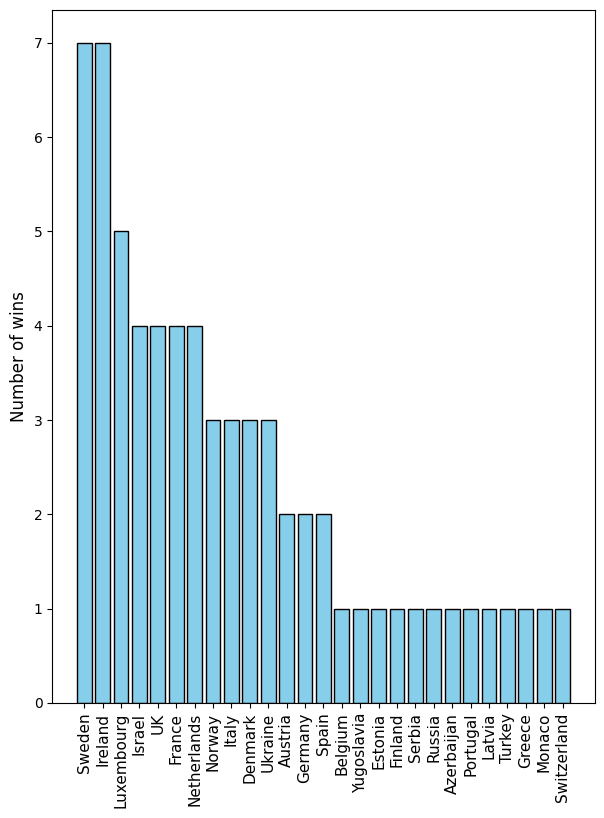

In [17]:

cw = win_table['win_count']
x = win_table['country']

idx_sort = cw.argsort()
cw = cw[idx_sort[::-1]]
x = x[idx_sort[::-1]]

plt.figure(figsize=(7, 9))
plt.bar(x, cw, color='skyblue', edgecolor='black')
plt.xticks(rotation=90, fontsize=11)
plt.ylabel('Number of wins', fontsize=12)
# plt.title('Winners of the Eurovision Song Contest')
plt.savefig('Images/Winners_of_the_Eurovision_Song_Contest.png')
plt.show()

C:\Users\mate1\AppData\Local\Temp\ipykernel_4560\3692086172.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(x['country'], rotation=90, fontsize=11)
C:\Users\mate1\AppData\Local\Temp\ipykernel_4560\3692086172.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(x, rotation=90, fontsize=11)


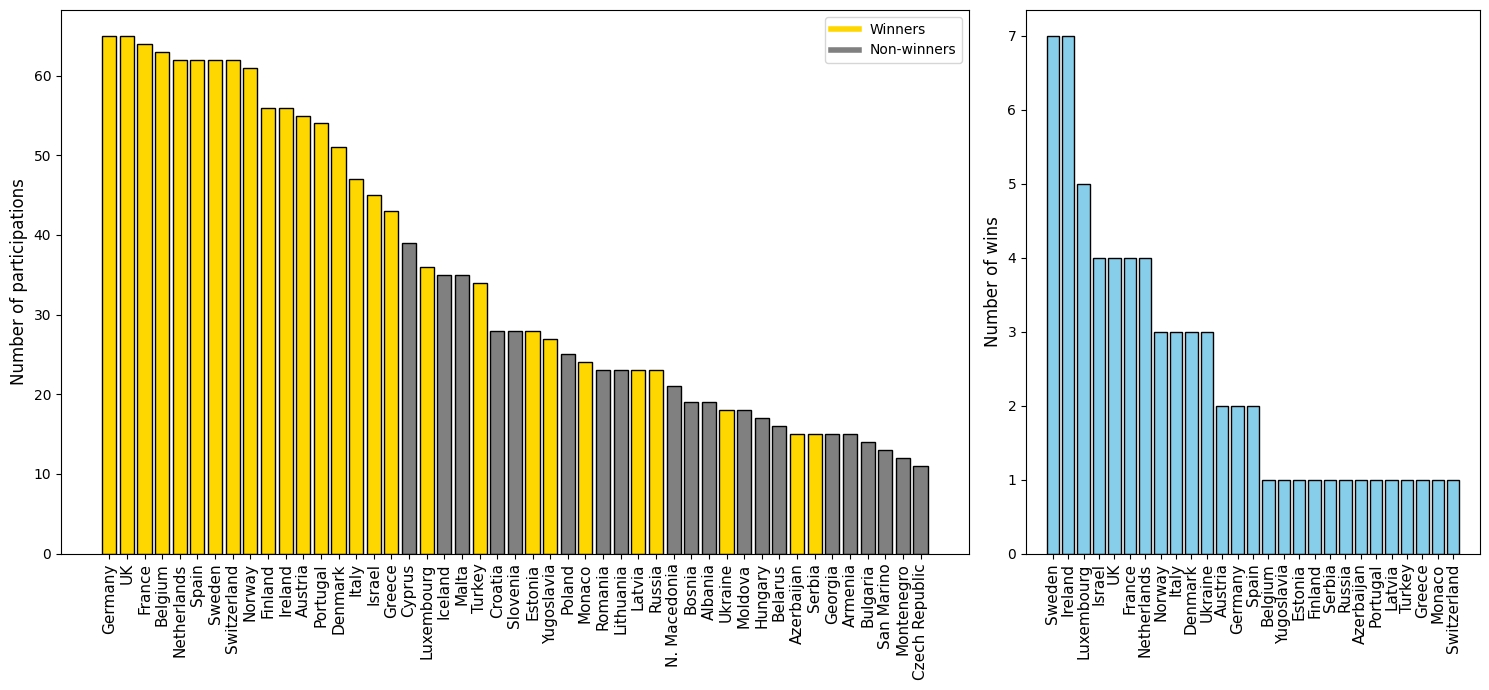

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7), width_ratios=[2, 1])

# Define the set of winning countries
winning_countries = set(win_table['country'])

# Plot the number of participations of each country with a minimum of 10 participations
x = participation_counts[participation_counts['participation_count'] >= 10]
colors = ['grey' if country not in winning_countries else 'gold' for country in x['country']]
ax[0].bar(x['country'], x['participation_count'], color=colors, edgecolor='k')
ax[0].set_xticklabels(x['country'], rotation=90, fontsize=11)
ax[0].set_ylabel('Number of participations', fontsize=12)


# Add a legend to indicate the significance of the colors
ax[0].legend(
    handles=[
        plt.Line2D([0], [0], color='gold', lw=4, label='Winners'),
        plt.Line2D([0], [0], color='grey', lw=4, label='Non-winners')
    ],
    loc='upper right'
)

# Plot the number of wins of each country
cw = win_table['win_count']
x = win_table['country']

idx_sort = cw.argsort()
cw = cw[idx_sort[::-1]]
x = x[idx_sort[::-1]]

ax[1].bar(x, cw, color='skyblue', edgecolor='black')
ax[1].set_xticklabels(x, rotation=90, fontsize=11)
ax[1].set_ylabel('Number of wins', fontsize=12)

plt.tight_layout()
plt.savefig('Images/Participations_and_wins.png')
plt.show()


In [19]:
# # Delete the countries with less than 10 participations
# participation_counts = participation_counts[participation_counts['participation_count'] >= 10]

# # Update the dataframe
# df_final_round = df_final_round[df_final_round['from_country'].isin(participation_counts['country'])]
# df_final_round = df_final_round[df_final_round['to_country'].isin(participation_counts['country'])]
# df_final_round

In [20]:
# Up to year 2015 put the total point given by a country to another country also in the jury points
df_final_round.loc[df_final_round['year'] <= 2015, 'jury_points'] = df_final_round.loc[df_final_round['year'] <= 2015]['total_points']
df_final_round

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,Austria,Netherlands,6,NaN,6.0
1,1957,final,at,fr,Austria,France,0,NaN,0.0
2,1957,final,at,dk,Austria,Denmark,0,NaN,0.0
3,1957,final,at,lu,Austria,Luxembourg,3,NaN,3.0
4,1957,final,at,de,Austria,Germany,0,NaN,0.0
...,...,...,...,...,...,...,...,...,...
51349,2023,final,wld,al,World,Albania,6,6.0,NaN
51350,2023,final,wld,pt,World,Portugal,0,0.0,NaN
51351,2023,final,wld,rs,World,Serbia,0,0.0,NaN
51352,2023,final,wld,gb,World,UK,0,0.0,NaN


### Country analyzer

#### One country analyzer

Number of points given by Spain before 1997 and after 1997 + Boxplot of normalized points

In [21]:
# Function to obtain the number of points given for a given country during a time period

def family_points(df_final_round, country_id, initial_year, crop=15):
    
    # Get the number of points given by country_id to each country
    friends = df_final_round.query(f'year >= {initial_year} and from_country=="{country_id}"')
    
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14,7))
    gs = axs[1,0].get_gridspec()
    for ax in axs[1,:]:
        ax.remove()
    axbig = fig.add_subplot(gs[1,:])
    
    def normalize(df):
        return df / df.sum()
    
    fig.suptitle(f'Points given by {country_id} to each country since {initial_year}', fontsize=16)
    # fig.tight_layout()


    # Plot the  normalized number of jury points given by country_id to each country
    friends1 = friends.groupby('to_country')['jury_points'].sum().sort_values(ascending=False)
    indices = friends1.index
    indices = indices[:crop]
    friends1 = normalize(friends1)
    friends1 = friends1.reset_index()
    friends1.columns = ['country', 'points']
    friends1 = friends1.head(crop)
    x = friends1['country']
    y = friends1['points']
    axs[0,0].bar(x, y, label='Jury')
    # axs[0,0].set_title(f'Normalized points given by {country_id} to each country')
    axs[0,0].set_xticklabels(x, rotation=90, fontsize=10)
    axs[0,0].set_ylabel('Normalized points', fontsize=12)
    axs[0,0].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, fontsize=12)
    
    
    # Plot the number of televote points given by country_id to each country
    friends2 = friends.groupby('to_country')['tele_points'].sum().sort_values(ascending=False)
    friends2 = friends2 / friends2.sum()
    friends2 = friends2.reset_index()
    friends2.columns = ['country', 'points']
    friends2 = friends2.head(crop)
    x = friends2['country']
    y = friends2['points']
    axs[0,1].bar(x, y, label='Televote', color='orange')
    # axs[0,1].set_title(f'Normalized Points given by {country_id} to each country')
    axs[0,1].set_xticklabels(x, rotation=90, fontsize=10)
    axs[0,1].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, fontsize=12)
    
    
    # Boxplot of the total points given by country_id to each country though the years
    friends_sorted = friends.groupby(['to_country', 'year'])['jury_points'].sum().reset_index()    
    # t = friends_sorted.groupby('to_country').sum().sort_values('jury_points', ascending=False).index
    # t = t[:crop]
    
    sns.boxplot(data=friends_sorted[friends_sorted['to_country'].isin(indices)], x='to_country', y='jury_points', order=indices, ax=axbig, palette='light:#5A9', linewidth=0.5, fliersize=2, medianprops={"color": "k", "linewidth": 1})
        
    axbig.set_xticklabels(axbig.get_xticklabels(), rotation=90, fontsize=10)
    axbig.set_ylabel('Points', fontsize=12)
    axbig.set_title(f'Jury points distribution over the years')
    axbig.set_xlabel('')
    
    
    plt.subplots_adjust(hspace=0.6)  # Adjust the spacing (increase for more space)
    plt.savefig(f'Images/{country_id}_points.png')

    plt.show()
    
    
    return 


C:\Users\mate1\AppData\Local\Temp\ipykernel_4560\1961262759.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,0].set_xticklabels(x, rotation=90, fontsize=10)
C:\Users\mate1\AppData\Local\Temp\ipykernel_4560\1961262759.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,1].set_xticklabels(x, rotation=90, fontsize=10)


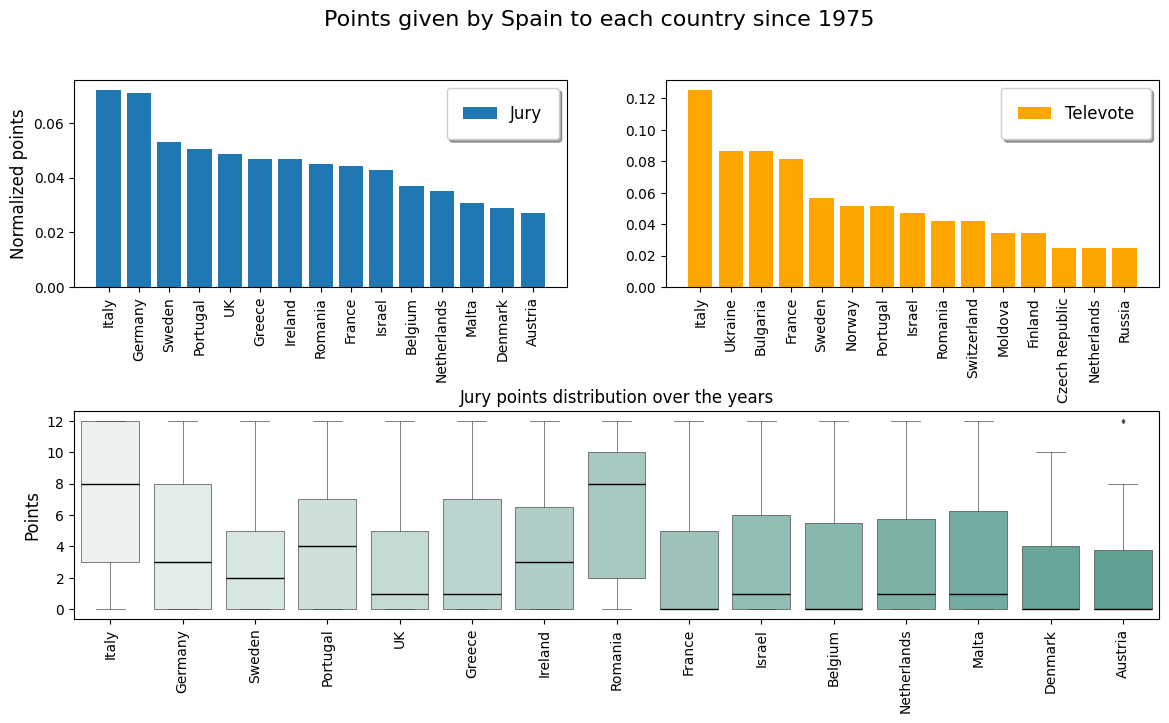

In [22]:
family_points(df_final_round, country_id='Spain', initial_year=1975)

C:\Users\mate1\AppData\Local\Temp\ipykernel_4560\1961262759.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,0].set_xticklabels(x, rotation=90, fontsize=10)
C:\Users\mate1\AppData\Local\Temp\ipykernel_4560\1961262759.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,1].set_xticklabels(x, rotation=90, fontsize=10)


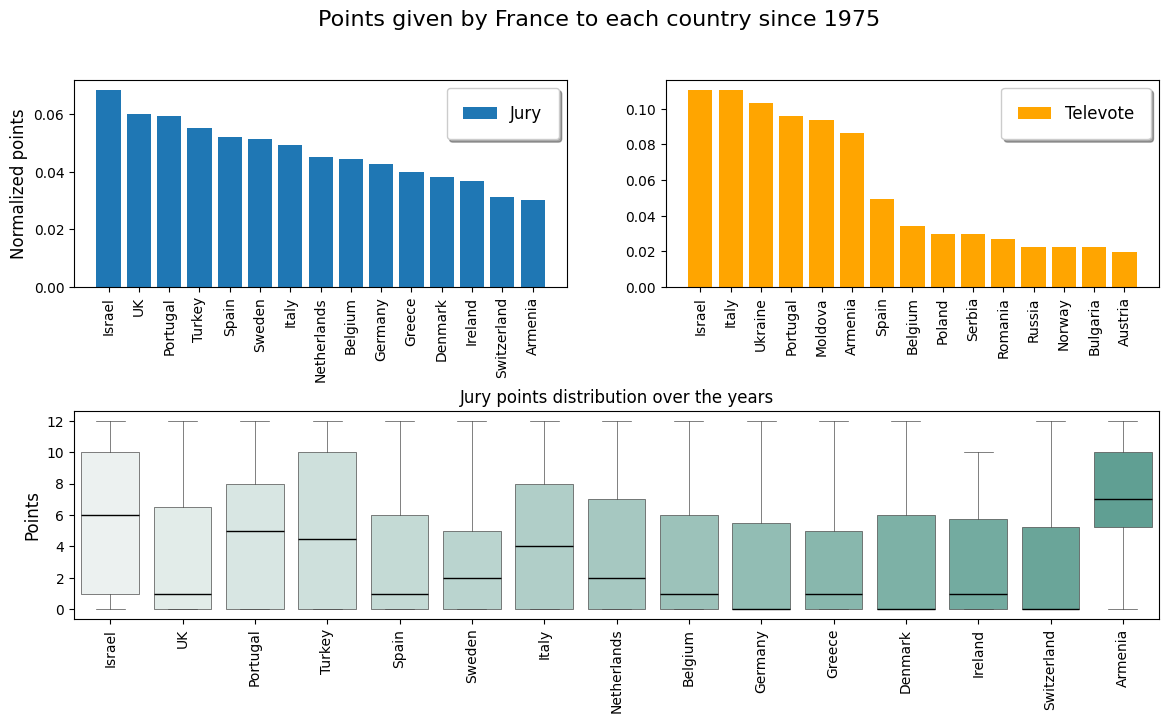

In [23]:
family_points(df_final_round, country_id='France', initial_year=1975)

C:\Users\mate1\AppData\Local\Temp\ipykernel_4560\1961262759.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,0].set_xticklabels(x, rotation=90, fontsize=10)
C:\Users\mate1\AppData\Local\Temp\ipykernel_4560\1961262759.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,1].set_xticklabels(x, rotation=90, fontsize=10)


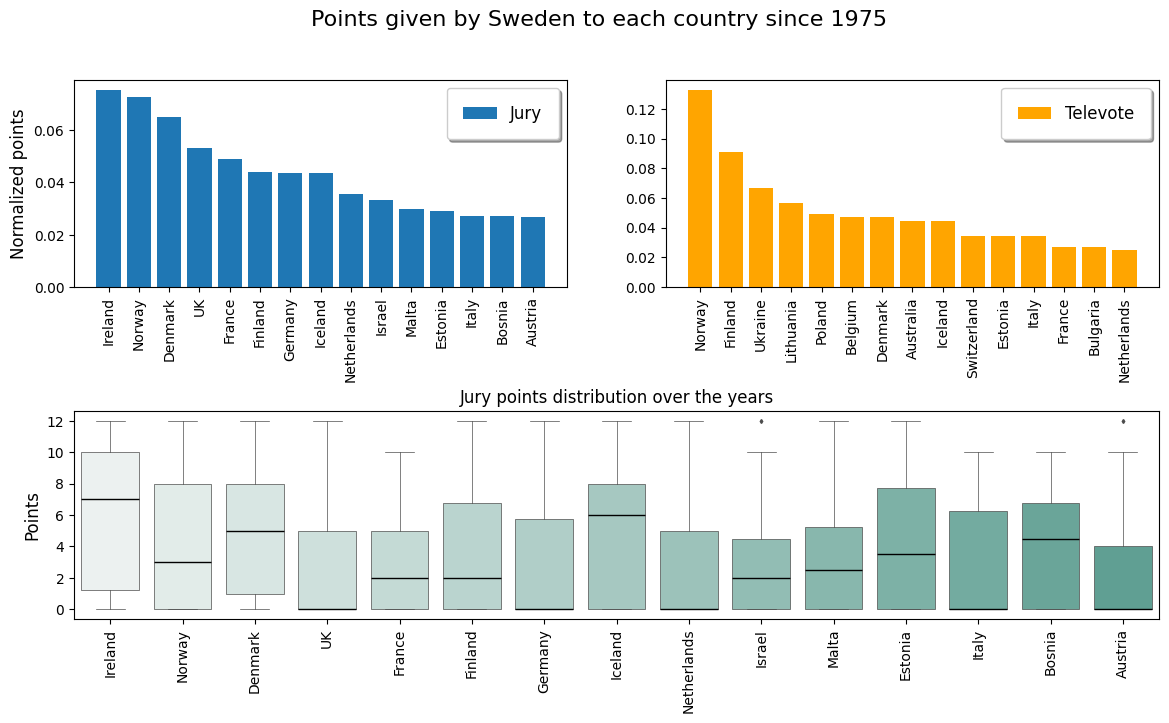

In [24]:
family_points(df_final_round, country_id='Sweden', initial_year=1975)

## Analysis

### Tree diagram of cohesion cluster analysis

In this cluster analysis we compare the voting portfolios between countries for different range of years, by applying the Wards method and euclidean distance which produce the least biased results. The Warts method seeks to minimize the total within-cluster variance as clusters are merged. At each step of the algorithm:

- It computes the increase in total within-cluster variance that would result from merging any two clusters.
- It selects the pair of clusters whose merging causes the smallest increase in this variance.

This leads to a hierarchy of clusters, visualized as a dendrogram.

### Study of Bias

We define quality as the average aggregate number of points from all the other country juries to song $C_j$ in year $t$:

$$\text{Quality}\quad C_{jt} = \frac{1}{p-2}\sum_{p\neq i,j} C_{ijt}$$

Thenb, the bias is defined as:

$$\text{Bias} \, C_{ijt} = \text{Vote} \, C_{ijt} - \text{Quality} \, C_{jt}$$

In [25]:
def bias_dyads(df, initial_year, final_year, N_top=15):
    
    # Filter the data
    df_filtered = df[(df['year'] >= initial_year) & (df['year'] <= final_year)]
    participations = participation_counts_f(df, initial_year, final_year)
    
    # Delete the countries with less than 10 participations
    participations = participations[participations['participation_count'] >= 5]
    
    # Update the dataframe
    df_filtered = df_filtered[df_filtered['from_country'].isin(participations['country'])]
    
    # Obtain the total points given by each country to each other
    given_points_yearly = df_filtered.groupby(['year', 'to_country'])['jury_points'].sum().unstack().fillna(0)
    
    # Obtain the number of participants of each year
    participants = df_filtered.groupby('year')['from_country'].nunique()
    
    # Create a dataframe to store the quality of country song per year
    quality = pd.DataFrame(0.0, index=participants.index, columns=given_points_yearly.columns)
    
    # Compute the quality of the song of each country per year
    for year in participants.index:
        for country in given_points_yearly.columns:
            quality.loc[year, country] = given_points_yearly.loc[year, country] / (participants.loc[year] - 2)
    
    # Compute the average bias of each country to each other
    bias = pd.DataFrame(0.0, index=given_points_yearly.columns, columns=given_points_yearly.columns)
    counts = pd.DataFrame(0, index=given_points_yearly.columns, columns=given_points_yearly.columns)
    p_values = pd.DataFrame(0.0, index=given_points_yearly.columns, columns=given_points_yearly.columns)
    
    for country in given_points_yearly.columns:
        for country2 in given_points_yearly.columns:
            if country != country2:
                total_bias = 0
                count = 0
                all_biases = []
                for year in participants.index:
                    # Check if both countries participated in the same year
                    countries_in_year = df_filtered[df_filtered['year'] == year]['to_country'].values
                    if country in countries_in_year and country2 in countries_in_year:
                        points_between = df_filtered[
                            (df_filtered['year'] == year) & 
                            (df_filtered['from_country'] == country) & 
                            (df_filtered['to_country'] == country2)
                        ]['jury_points'].sum()  # Ensure it sums to a scalar value
                        
                        # Compute bias for this year
                        b = points_between - quality.loc[year, country2]
                        all_biases.append(b)
                        total_bias += b
                        count += 1
                        
                # Perform t-test for p-values
                t_stat, p_value = stats.ttest_1samp(all_biases, 0)  # Test against 0 (null hypothesis)
                
                # Store the results
                p_values.loc[country, country2] = p_value
                counts.loc[country, country2] = count
                if count > 0:
                    bias.loc[country, country2] = round(total_bias / count, 2)
    
    # Ensure index names are set correctly
    bias.index = bias.index.rename('from_country')
    counts.index = counts.index.rename('from_country')
    p_values.index = p_values.index.rename('from_country')

    # Reset index and reshape the DataFrame using .melt()
    bias_reset = bias.reset_index().melt(id_vars=['from_country'], value_vars=bias.columns, var_name='to_country', value_name='bias')
    counts_reset = counts.reset_index().melt(id_vars=['from_country'], value_vars=counts.columns, var_name='to_country', value_name='count')
    p_values_reset = p_values.reset_index().melt(id_vars=['from_country'], value_vars=p_values.columns, var_name='to_country', value_name='p_value')


    # Merge the bias, counts and p-values into a single DataFrame
    result = pd.merge(bias_reset, counts_reset, on=['from_country', 'to_country'])
    result = pd.merge(result, p_values_reset, on=['from_country', 'to_country'])

    # Sort based on biased dyads
    result = result.sort_values('bias', ascending=False)
    result = result[result['count'] > 1]
    # result = result.head(N_top)
    
    return result


In [26]:
bias1 = bias_dyads(df_final_round, initial_year=1998, final_year=2023)
bias1.head(15)

C:\Users\mate1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\mate1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\mate1\AppData\Local\Temp\ipykernel_4560\2477753850.py:55: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(all_biases, 0)  # Test against 0 (null hypothesis)


,from_country,to_country,bias,count,p_value
488,Greece,Cyprus,10.05,11,3.701563e-10
856,Cyprus,Greece,9.16,11,1.281611e-07
1317,Armenia,Montenegro,8.89,2,1.442667e-01
29,N. Macedonia,Albania,8.72,4,1.588130e-03
1303,Romania,Moldova,8.27,10,3.450278e-05
2072,Azerbaijan,Turkey,8.20,4,3.127040e-04
1400,Serbia,N. Macedonia,8.02,3,2.594998e-02
232,Turkey,Azerbaijan,7.98,4,3.047516e-04
1625,Moldova,Romania,7.71,10,1.101450e-04
777,Lithuania,Georgia,7.64,5,1.101567e-03


In [27]:
print(bias1.head(15).to_latex(index=False, float_format="{:.2f}".format))

\begin{tabular}{llrrr}
\toprule
from_country & to_country & bias & count & p_value \\
\midrule
Greece & Cyprus & 10.05 & 11 & 0.00 \\
Cyprus & Greece & 9.16 & 11 & 0.00 \\
Armenia & Montenegro & 8.89 & 2 & 0.14 \\
N. Macedonia & Albania & 8.72 & 4 & 0.00 \\
Romania & Moldova & 8.27 & 10 & 0.00 \\
Azerbaijan & Turkey & 8.20 & 4 & 0.00 \\
Serbia & N. Macedonia & 8.02 & 3 & 0.03 \\
Turkey & Azerbaijan & 7.98 & 4 & 0.00 \\
Moldova & Romania & 7.71 & 10 & 0.00 \\
Lithuania & Georgia & 7.64 & 5 & 0.00 \\
Serbia & Bosnia & 7.57 & 5 & 0.00 \\
Croatia & Bosnia & 7.43 & 9 & 0.00 \\
Slovenia & Montenegro & 7.39 & 2 & 0.12 \\
Armenia & Georgia & 7.36 & 6 & 0.00 \\
Bosnia & Serbia & 7.21 & 5 & 0.00 \\
\bottomrule
\end{tabular}



In [28]:
bias2 = bias_dyads(df_final_round, initial_year=1975, final_year=1997)
bias2.head(10)

C:\Users\mate1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\mate1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\mate1\AppData\Local\Temp\ipykernel_4560\2477753850.py:55: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_1samp(all_biases, 0)  # Test against 0 (null hypothesis)


,from_country,to_country,bias,count,p_value
963,Malta,Slovakia,9.12,2,1.336411e-01
354,Cyprus,Greece,8.13,13,6.851667e-09
150,Greece,Cyprus,6.54,13,4.281141e-06
102,Turkey,Bosnia,6.24,4,3.975076e-02
633,Croatia,Malta,5.02,5,2.985813e-02
123,Malta,Croatia,4.80,5,6.728513e-02
931,Netherlands,Russia,4.74,2,3.077353e-01
613,Malta,Luxembourg,4.42,4,2.333770e-01
549,Portugal,Italy,4.31,17,4.888625e-05
1138,Malta,Turkey,4.02,7,1.465089e-02


In [29]:
print(bias2.head(15).to_latex(index=False, float_format="{:.2f}".format))

\begin{tabular}{llrrr}
\toprule
from_country & to_country & bias & count & p_value \\
\midrule
Malta & Slovakia & 9.12 & 2 & 0.13 \\
Cyprus & Greece & 8.13 & 13 & 0.00 \\
Greece & Cyprus & 6.54 & 13 & 0.00 \\
Turkey & Bosnia & 6.24 & 4 & 0.04 \\
Croatia & Malta & 5.02 & 5 & 0.03 \\
Malta & Croatia & 4.80 & 5 & 0.07 \\
Netherlands & Russia & 4.74 & 2 & 0.31 \\
Malta & Luxembourg & 4.42 & 4 & 0.23 \\
Portugal & Italy & 4.31 & 17 & 0.00 \\
Malta & Turkey & 4.02 & 7 & 0.01 \\
UK & Estonia & 3.86 & 3 & 0.19 \\
Finland & Estonia & 3.70 & 2 & 0.51 \\
Denmark & Monaco & 3.67 & 2 & 0.07 \\
Bosnia & Slovenia & 3.60 & 4 & 0.08 \\
Turkey & Yugoslavia & 3.50 & 12 & 0.00 \\
\bottomrule
\end{tabular}



Now we are ineterested in studying how different are the voting portfolios between different countries. First we compute the number of points given for all the countries to each country and normalize. Then, we compute the correlation matrix between countries based on their portfolios. After that, we compute the distance between correlations and plot a dendogram.

In [30]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as sch

In [31]:
# Convert correlation matrix to distance matrix
def correlation_to_distance(corr):
    return np.sqrt(2 * (1 - corr))

# Correlation function
def correlation(df, initial_year, final_year, bootstraping=1000):
    
    # Filter data in time
    friends = df.query(f'year >= {initial_year} and year <= {final_year}')
    participations = participation_counts_f(df, initial_year, final_year)
    
    # # Delete the countries with less than 10 participations
    participations = participations[participations['participation_count'] > 1]

    # # Update the dataframe
    friends = friends[friends['from_country'].isin(participations['country'])]
    friends = friends[friends['to_country'].isin(participations['country'])]
    
    # Get the number of points given by each country to each country
    friends = friends.groupby(['from_country', 'to_country'])['jury_points'].mean().unstack().fillna(0)
    
    # Get the correlation matrix
    corr = friends.T.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, cmap='coolwarm', annot=False) 
    plt.title('Correlation matrix of the points given by each country to each country')
    plt.xlabel('Country')
    plt.ylabel('Country')
    plt.show()
    
    return corr

def boots_correlation(df, initial_year, final_year, bootstraping=100000, p_threshold=0.1):
    
    # Filter data within the specified time range
    friends = df.query(f'year >= {initial_year} and year <= {final_year}')
    participations = participation_counts_f(df, initial_year, final_year)
    
    # Remove countries with fewer than 7 participations
    participations = participations[participations['participation_count'] > 5]
    valid_countries = participations['country']
    
    # Filter valid countries
    friends = friends[friends['from_country'].isin(valid_countries)]
    # friends = friends[friends['to_country'].isin(valid_countries)]
    
    # Create a pivot table of mean jury points
    sampled = friends.groupby(['from_country', 'to_country'])['jury_points'].mean().unstack().fillna(0)
    
    # Store bootstrapped correlation matrices
    bootstraped_corr = []
    full_index = sampled.index  # Full list of countries
    
    sampled_corr = sampled.T.corr(method='pearson')
    sampled_corr = sampled_corr.fillna(0)
    bootstraped_corr.append(sampled_corr.values)
    
    p_value = np.zeros((sampled_corr.shape[0], sampled_corr.shape[1]))
    
    for _ in range(bootstraping):
        
        # Bootstrap the data
        # Resample original data with replacement to estimate variability or confidence intervals for your observed correlations.
        resample_pivot = sampled.sample(frac=1, replace=True, axis=1)
        # Calculate the correlation matrix
        resample_corr = resample_pivot.T.corr(method='pearson')
        resample_corr = resample_corr.fillna(0)
        # Reindex to ensure consistent shape
        bootstraped_corr.append(resample_corr.values)
        
        # p-value calculation
        # Randomly shuffle the values in each column
        randomized_sampled = sampled.apply(np.random.permutation, axis=0)
        # Calculate the correlation matrix for the randomized data
        randomized_corr = randomized_sampled.T.corr(method='pearson')
        randomized_corr = randomized_corr.fillna(0)
        # Update p-value matrix: Count cases where the randomized correlation is greater in absolute value
        p_value += (np.abs(randomized_corr) >= np.abs(sampled_corr)).values
        
    # Normalize p-values
    p_value /= bootstraping
    # Turn into DataFrame
    p_value = pd.DataFrame(p_value, index=full_index, columns=full_index)

    # Compute the mean correlation matrix from bootstraps
    mean_c = np.mean(bootstraped_corr, axis=0)
    mean_correlation = pd.DataFrame(mean_c, index=full_index, columns=full_index)
    
    # Plot the heatmap
    plt.figure(figsize=(14, 10))
    ax = sns.heatmap(mean_correlation, cmap='PiYG', annot=False, xticklabels=True, yticklabels=True, vmin=np.min(mean_correlation), vmax=np.max(mean_correlation), cbar_kws={'label': 'Pearson Correlation'}, linewidths=0.15, label='big')
    ax.figure.axes[-1].yaxis.label.set_size(14)
    # plt.title('Mean Correlation Matrix of voting portfolios')
    plt.xlabel('')
    plt.ylabel('')
    
    # plt.savefig(f'Images/Mean_Correlation_Matrix_from_{initial_year}_to_{final_year}.png')
    plt.show()
    
    plt.figure(figsize=(14, 10))
    ax = sns.heatmap(p_value, cmap='bone', annot=False, xticklabels=True, yticklabels=True, vmin=0, vmax=0.1, cbar_kws={'label': 'P-value'}, linewidths=0.15, label='big')
    ax.figure.axes[-1].yaxis.label.set_size(14)
    # plt.title('P-value Matrix of voting portfolios')
    plt.xlabel('')
    plt.ylabel('')
    
    # plt.savefig(f'Images/P_value_Matrix_from_{initial_year}_to_{final_year}.png')
    plt.show()

    # If the p-value is less than the threshold, set the correlation to 0
    mean_correlation[p_value > p_threshold] = 0
    
    return mean_correlation, p_value


# Hierarchical clustering function
def hierarchical_clustering(corr):
    
    # Convert correlation matrix to distance matrix
    dist = correlation_to_distance(corr)
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(dist, cmap='coolwarm', annot=False)
    plt.title('Distance matrix of the points given by each country to each country')
    
    # Flatten the distance matrix
    dist = squareform(dist, checks=False)
    
    # Perform hierarchical clustering non-euclidean distance
    Z = linkage(dist, method='ward', metric='sqeuclidean')

    return Z, corr, dist

def plotting_dendrogram(Z, corr, threshold=0.5):
    
    # Plot the dendrogram
    plt.figure(figsize=(18, 10))
    sch.dendrogram(Z, labels=corr.index, orientation='right', color_threshold=threshold, leaf_font_size=11)
    plt.axvline(x=threshold, color='black', linestyle='--')
    plt.xlim(Z[:, 2].min()-0.1, Z[:, 2].max()+0.1)
    # plt.title('Dendrogram of the points given by each country to each country')
    # plt.savefig(f'Images/Dendrogram_from_{initial_year}_to_{final_year}.png')
    plt.show()
    
    return

def get_clusters(Z, corr, cutoff_distance):
    
    # Get the cluster labels
    cluster_labels = fcluster(Z, t=cutoff_distance, criterion='distance')
    # Create a DataFrame with the cluster labels
    clusters = pd.DataFrame(cluster_labels, index=corr.index, columns=['cluster'])
    clusters = clusters.sort_values('cluster')
    
    return clusters

def bias_among_cluster(cluster, df, initial_year, final_year):
    
    # Filter the data
    df_filtered = df[(df['year'] >= initial_year) & (df['year'] <= final_year)]
    participations = participation_counts_f(df, initial_year, final_year)
    
    # Delete the countries with less than 5 participations
    # participations = participations[participations['participation_count'] > 0]
    
    # Update the dataframe
    # df_filtered = df_filtered[df_filtered['from_country'].isin(participations['country'])]
    # df_filtered = df_filtered[df_filtered['to_country'].isin(participations['country'])]
    
    # Obtain the total points given by each country to each other
    given_points_yearly = df_filtered.groupby(['year', 'to_country'])['jury_points'].sum().unstack().fillna(0)
    
    # Obtain the number of participants of each year
    participants = df_filtered.groupby('year')['from_country'].nunique()
    
    # Create a dataframe to store the quality of country song per year
    quality = pd.DataFrame(0.0, index=participants.index, columns=given_points_yearly.columns)
    
    # Compute the quality of the song of each country per year
    for year in participants.index:
        for country in given_points_yearly.columns:
            quality.loc[year, country] = given_points_yearly.loc[year, country] / (participants.loc[year] - 2)

    # Get the different clusters
    cluster_types = cluster['cluster'].unique()
    
    # Create a DataFrame to store the results
    results = pd.DataFrame(np.nan, index=cluster_types, columns=participants.index)
    p_values = pd.DataFrame(np.nan, index=cluster_types, columns=participants.index)
    
    # Add an average column
    results['average'] = np.nan
    p_values['average'] = np.nan
    
    for c in cluster_types:
        
        # Get the countries in the cluster
        countries = cluster[cluster['cluster'] == c].index
        
        for year in participants.index:
            total_bias = 0
            count = 0
            all_biases = []
            for country in countries:
                for country2 in countries:
                    if country != country2:
                        # Check if both countries participated in the same year
                        countries_in_year = df_filtered[df_filtered['year'] == year]['to_country'].values
                        if country in countries_in_year and country2 in countries_in_year:
                            points_between = df_filtered[
                                    (df_filtered['year'] == year) & 
                                    (df_filtered['from_country'] == country) & 
                                    (df_filtered['to_country'] == country2)
                                ]['jury_points'].sum()
                                
                            # Compute bias for this year
                            b = points_between - quality.loc[year, country2]
                            all_biases.append(b)
                            total_bias += b
                            count += 1
                            
            # Perform t-test for p-values
            t_stat, p_value = stats.ttest_1samp(all_biases, 0)
                    
            # Store the results
            p_values.loc[c, year] = p_value
            results.loc[c, year] = total_bias / count if count > 0 else np.nan
        
        # Compute the average bias for the cluster
        results.loc[c, 'average'] = results.loc[c].mean()
        p_values.loc[c, 'average'] = stats.ttest_1samp(results.loc[c].dropna(), 0)[1]
        
        
    return results, p_values

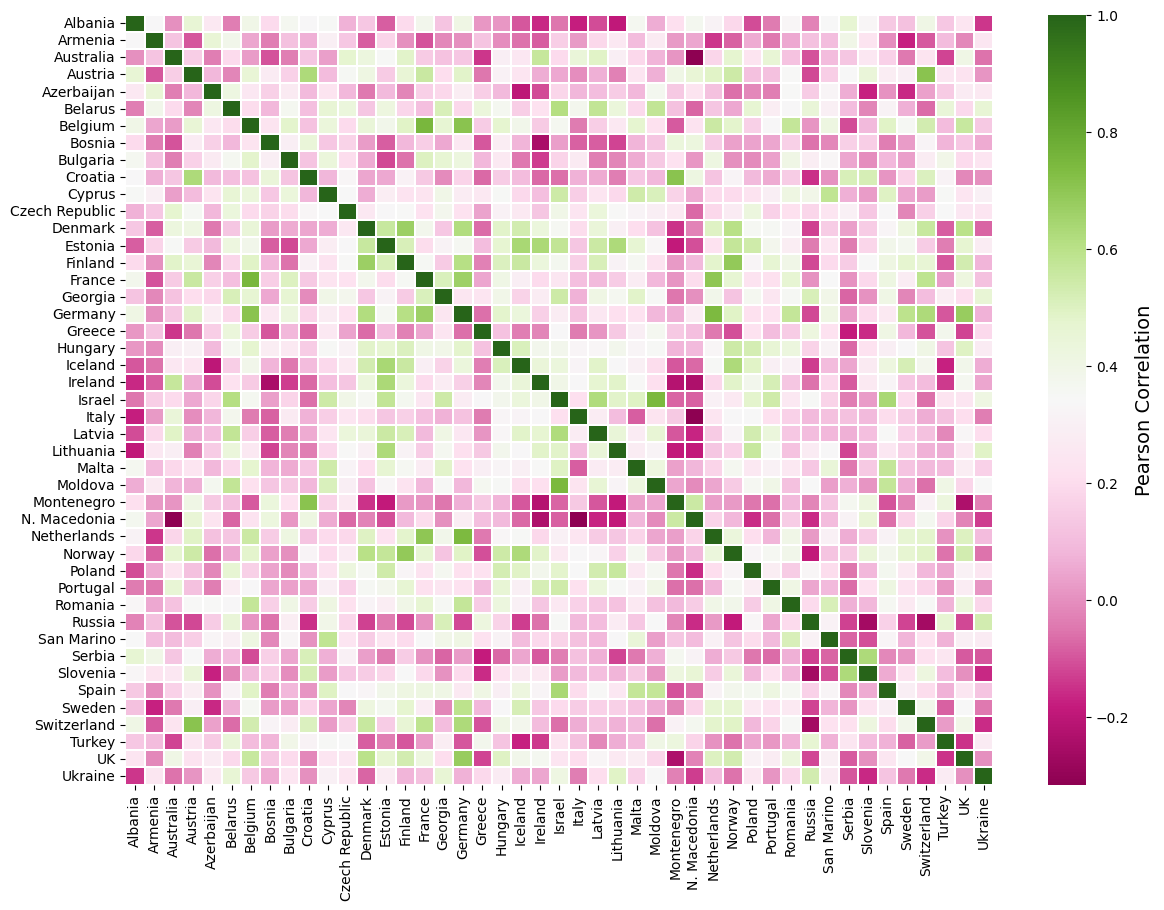

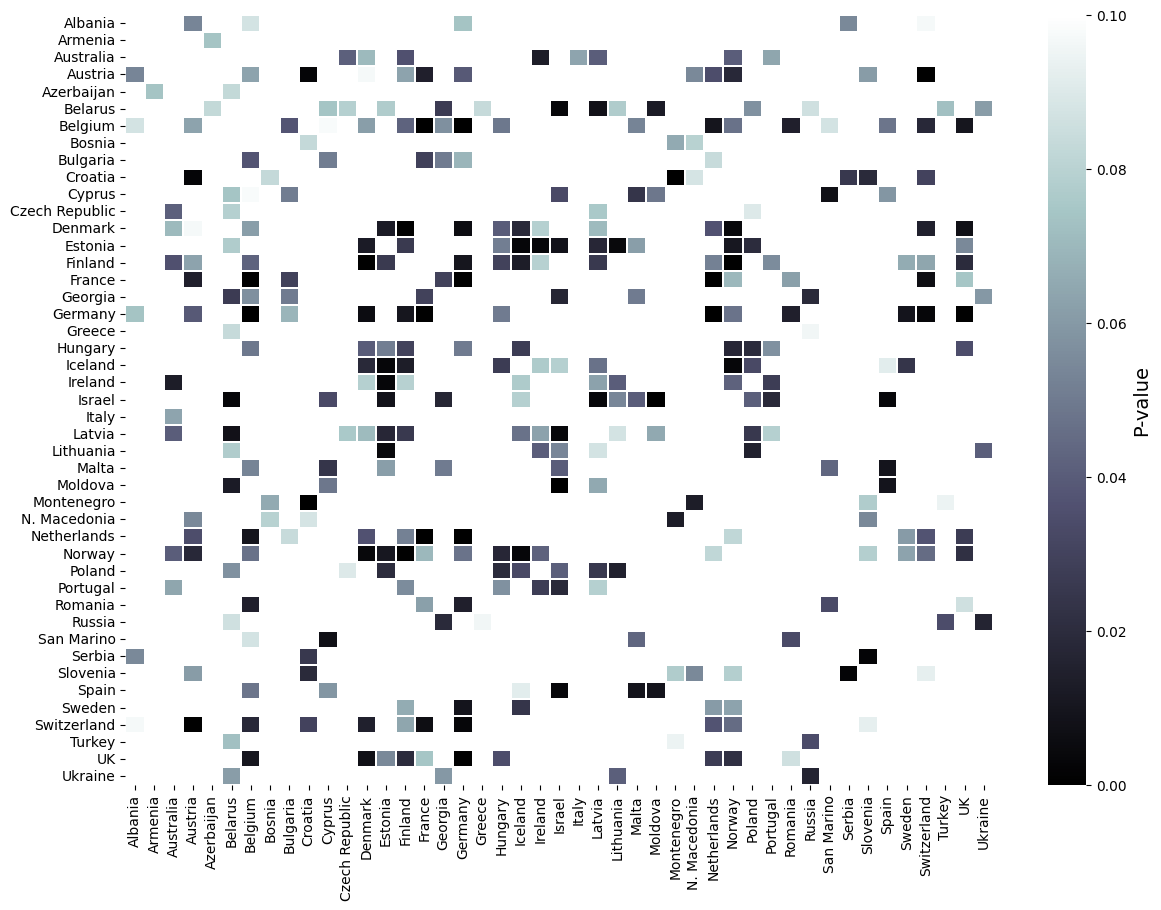

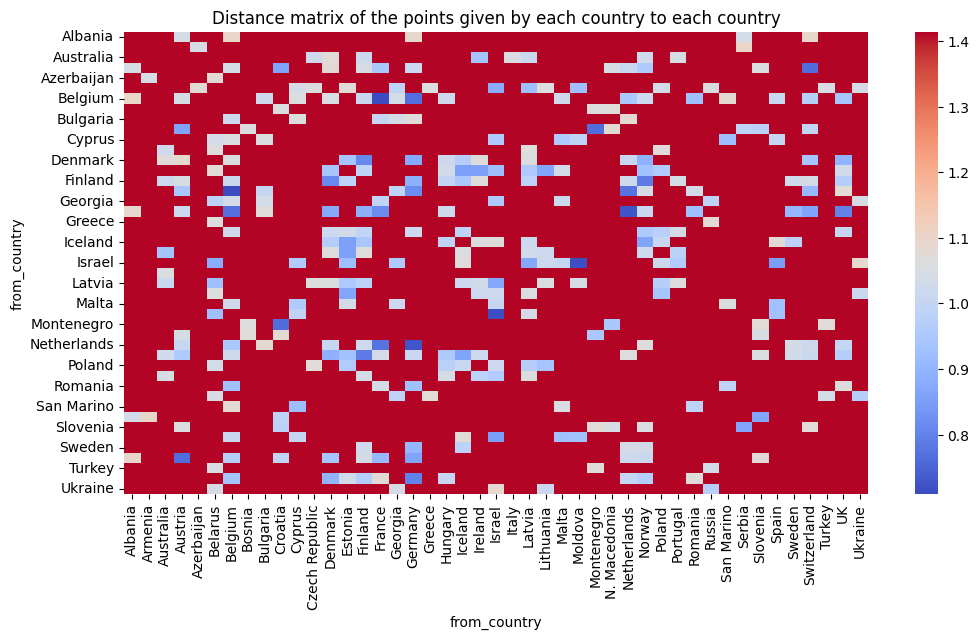

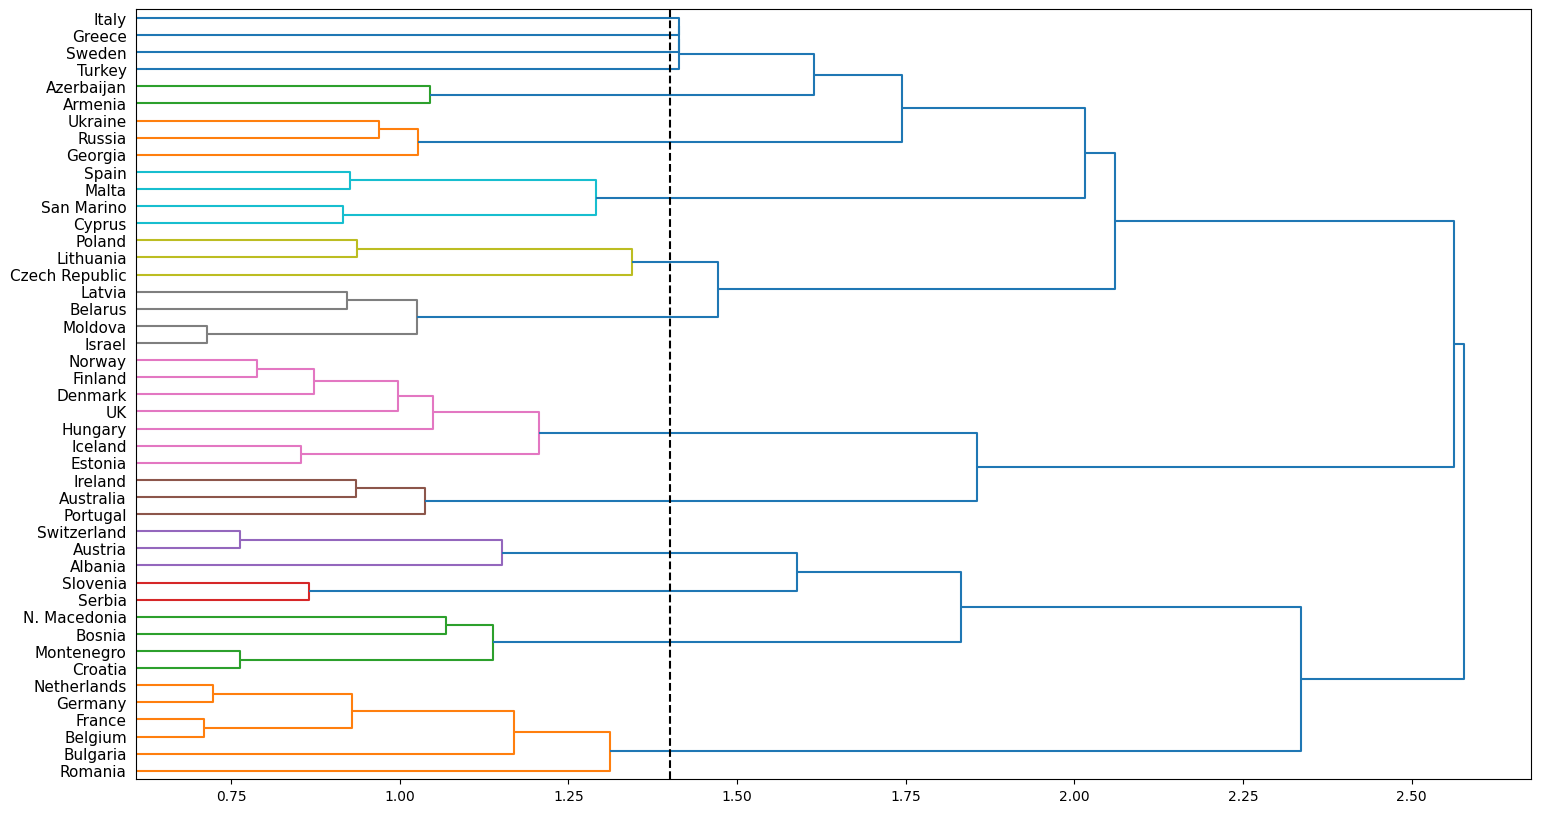

array([[ 6.        , 15.        ,  0.70962283,  2.        ],
       [22.        , 27.        ,  0.71429281,  2.        ],
       [17.        , 30.        ,  0.72345827,  2.        ],
       [ 9.        , 28.        ,  0.76332877,  2.        ],
       [ 3.        , 41.        ,  0.76371669,  2.        ],
       [14.        , 31.        ,  0.78776352,  2.        ],
       [13.        , 20.        ,  0.85365902,  2.        ],
       [37.        , 38.        ,  0.86487694,  2.        ],
       [12.        , 50.        ,  0.87225244,  3.        ],
       [10.        , 36.        ,  0.9165017 ,  2.        ],
       [ 5.        , 24.        ,  0.92187464,  2.        ],
       [26.        , 39.        ,  0.92583448,  2.        ],
       [45.        , 47.        ,  0.92928396,  4.        ],
       [ 2.        , 21.        ,  0.93441097,  2.        ],
       [25.        , 32.        ,  0.93577557,  2.        ],
       [35.        , 44.        ,  0.96903959,  2.        ],
       [43.        , 53.

In [32]:
threshold = 1.4
mean_corr, p_matrix = boots_correlation(df_final_round, initial_year=2006, final_year=2023)
Z, corr, dist = hierarchical_clustering(mean_corr)
plotting_dendrogram(Z, corr, threshold)
Z[Z[:, 2] < threshold]

In [219]:
cluster = get_clusters(Z, mean_corr, cutoff_distance=threshold)

cluster

# results, p_values = bias_among_cluster(cluster, df_final_round, initial_year=1998, final_year=2023)
# results

,cluster
from_country,
Albania,1
Netherlands,1
Austria,1
Germany,1
Switzerland,1
Belgium,1
France,1
N. Macedonia,2
Serbia,2


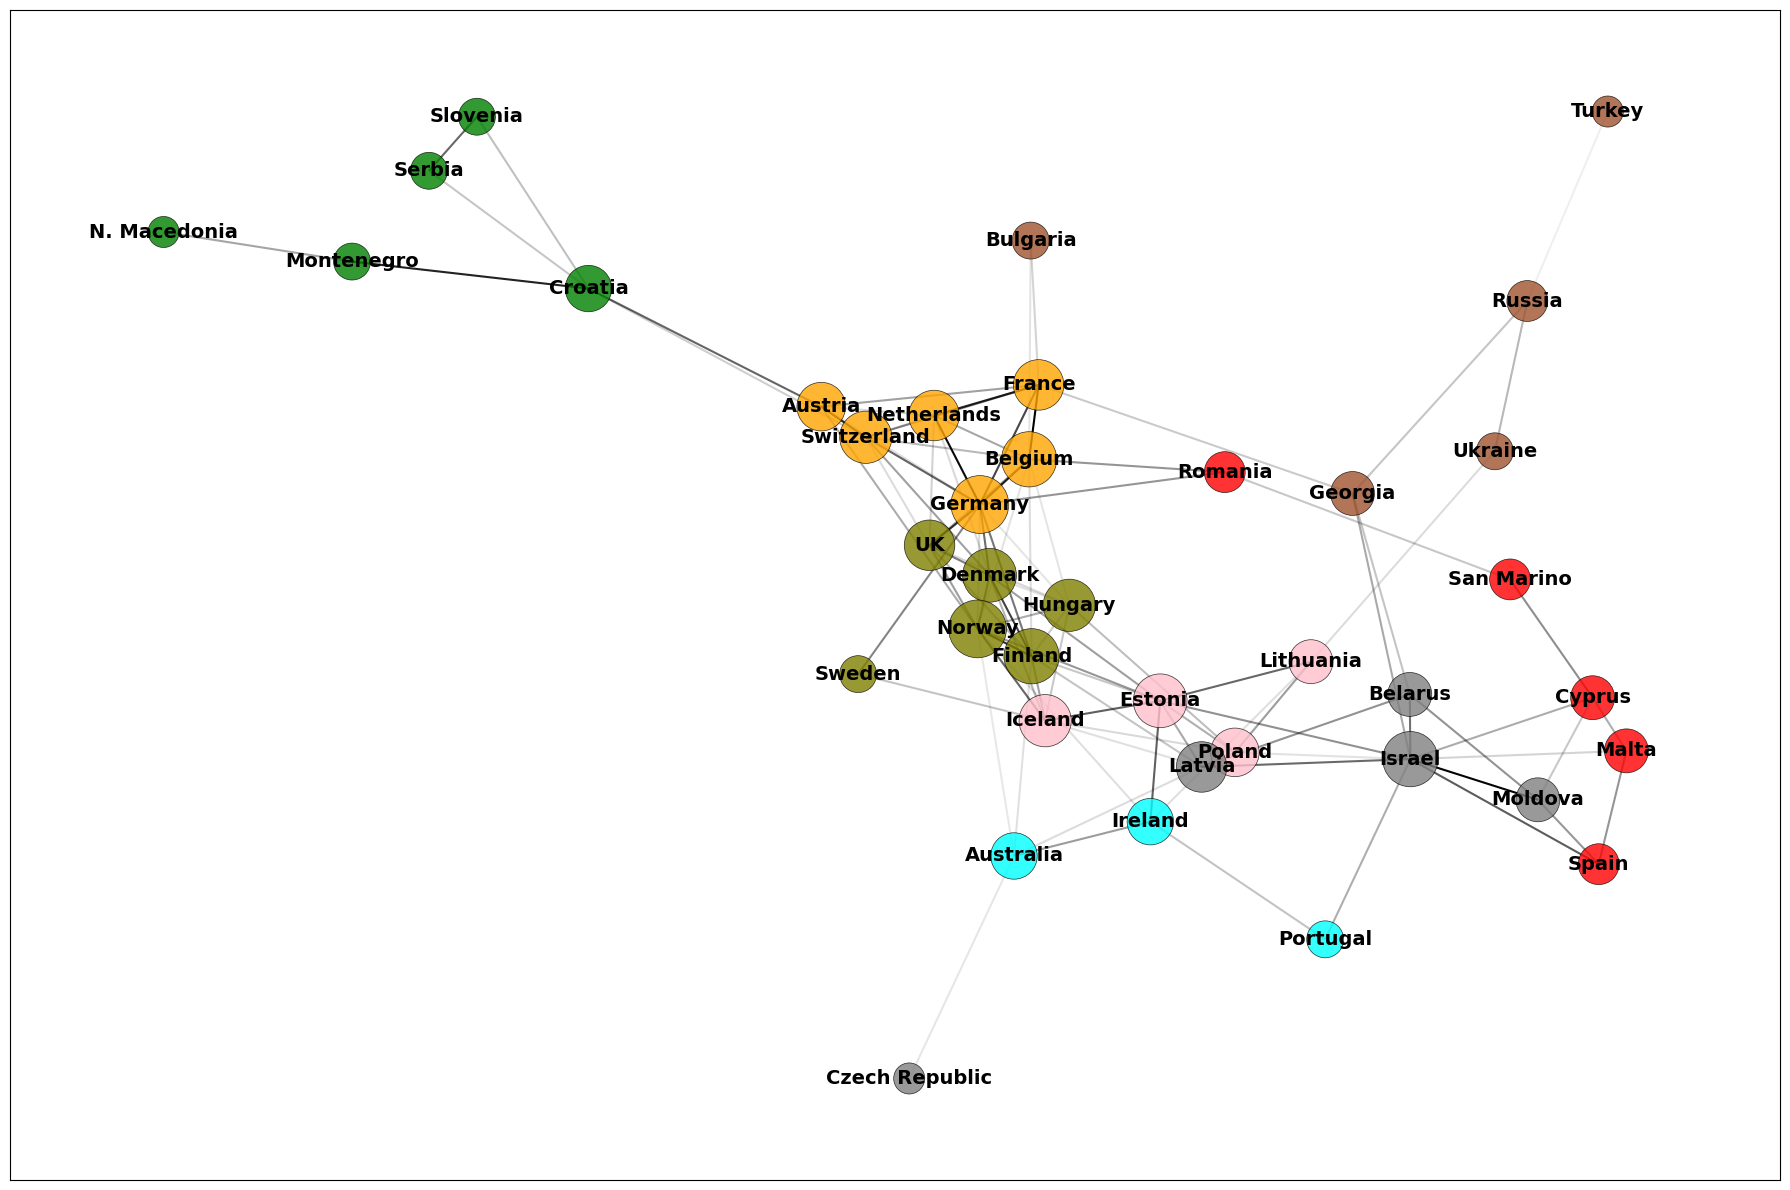

In [461]:
def create_network(p_matrix, cluster, corr, threshold=0.05):
    
    # Create a network from the p-value matrix
    G = nx.Graph()
    max_dist = dist.max().max()
    # Add nodes
    # G.add_nodes_from(cluster.index)
    # Add edges
    for i, row in cluster.iterrows():
        for j, column in cluster.iterrows():
            if i != j and p_matrix.loc[i, j] < threshold and corr.loc[i, j] > 0.3:
                G.add_edge(i, j, weight=corr.loc[i, j])
                    
    return G

def clusters_to_partition(cluster):
    
    # Create a partition from the cluster
    partition = {}
    for i, row in cluster.iterrows():
        partition[i] = row['cluster']
    return partition

def custom_layout(G, partition, same_community_weigth=5, different_community_weigth=1):
    
    pos = nx.spring_layout(G, weight=None)
    # Adjust the position of the nodes based on the partition
    for (u,v) in G.edges():
        if partition[u] == partition[v]:
            G[u][v]['weight'] = same_community_weigth
        else:
            G[u][v]['weight'] = different_community_weigth
            
    return pos

def plot_network(G, p_matrix, threshold=0.05):
    
    community_to_colour = {
        1: 'orange',
        2: 'green',
        3: 'red',
        4: 'purple',
        5: 'sienna',
        6: 'pink',
        7: 'grey',
        8: 'olive',
        9: 'cyan',
    }
    
    partition = clusters_to_partition(cluster)
    node_colors = [community_to_colour[partition[node]] for node in G.nodes()]
    edge_colors = [community_to_colour[partition[u]] for u, v in G.edges()]
    
    # # Apply custom layout
    # pos = custom_layout(G, partition)
    pos = nx.spring_layout(G)
    
    
    # Node deg
    node_deg = dict(G.degree)
    node_deg = [np.sqrt(node_deg[node]) * 500 for node in G.nodes()]
    
    # Draw the network
    plt.figure(figsize=(18, 12))
    # Create normalized alpha values for edges based on bias
    edge_bias = [G[u][v]['weight'] for u, v in G.edges()]
    norm = mcolors.Normalize(vmin=min(edge_bias), vmax=max(edge_bias))
    alphas = [norm(bias) for bias in edge_bias]
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_deg, alpha=0.8, edgecolors='k', linewidths=0.5)
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=alphas)
    nx.draw_networkx_labels(G, pos, font_size=14, font_color='black', font_weight='bold')
    plt.tight_layout()
    plt.savefig('Images/ESC_Network.png')
    # plt.show()
    
    
    return

threshold = 0.05
G = create_network(p_matrix, cluster, mean_corr, threshold=threshold)
plot_network(G, p_matrix, threshold=threshold)

In [273]:
from scipy.stats import binomtest

In [462]:
def cluster_voting_prob(df, cluster, initial_year, final_year, cluster_id):
    
    # Filter the data
    df_filtered = df[(df['year'] >= initial_year) & (df['year'] <= final_year)]
    cluster = cluster.sort_values('cluster')
    type_clusters = cluster['cluster'].unique()
    years = df_filtered['year'].unique()
    
    # Get the countries in the cluster
    countries  = cluster[cluster['cluster'] == cluster_id].index 
    
    # Create a DataFrame to store the results
    iterables = [[c for c in countries], ["Random", "Observed", "p-value"]]
    multi = pd.MultiIndex.from_product(iterables, names=["To Country", "Probability"])
    table = pd.DataFrame(np.nan, index=[countries], columns=multi)
    
    for country in countries:
        for country2 in countries:
            if country != country2:
                obs_prob = 0
                rand_prob = 0
                n = 0
                for year in years:
                    # Check if both countries participated in the same year
                    countries_in_year = df_filtered[df_filtered['year'] == year]['to_country'].values
                    if country in countries_in_year and country2 in countries_in_year:
                        points_between = df_filtered[
                                (df_filtered['year'] == year) & 
                                (df_filtered['from_country'] == country) & 
                                (df_filtered['to_country'] == country2)
                            ]['jury_points'].sum()
                        if points_between > 0:
                            obs_prob += 1
                        n += 1
                        
                        # Random probability
                        n_participants = df_filtered[df_filtered['year'] == year]['to_country'].nunique()
                        rand_prob += 10 / (n_participants-1)
                
                if n>0:
                    # P value
                    p_value = binomtest(obs_prob, n, p = rand_prob / n, alternative='greater').pvalue
                
                # Store the results
                table.loc[country, (country2, "Random")] = rand_prob / n if n > 0 else 0
                table.loc[country, (country2, "Observed")] = obs_prob / n if n > 0 else 0
                table.loc[country, (country2, "p-value")] = p_value if n > 0 else np.nan
                        
    return table
    

In [473]:
def voting_prob(df, initial_year, final_year):
    
    # Filter the data
    df_filtered = df[(df['year'] >= initial_year) & (df['year'] <= final_year)]
    # Delete the countries with less than 10 participations
    participations = participation_counts_f(df, initial_year, final_year)
    participations = participations[participations['participation_count'] > 5]
    
    df_filtered = df_filtered[df_filtered['from_country'].isin(participations['country'])]
    df_filtered = df_filtered[df_filtered['to_country'].isin(participations['country'])]
    
    
    countries = df_filtered['to_country'].unique()
    years = df_filtered['year'].unique()
    
    # Create a DataFrame to store the results
    iterables = [[c for c in countries], ["Random", "Observed", "p value"]]
    multi = pd.MultiIndex.from_product(iterables, names=["To Country", "Probability"])
    table = pd.DataFrame(np.nan, index=[countries], columns=multi)
    
    for country in countries:
        for country2 in countries:
            if country != country2:
                obs_prob = 0
                rand_prob = 0
                n = 0
                for year in years:
                    # Check if both countries participated in the same year
                    countries_in_year = df_filtered[df_filtered['year'] == year]['to_country'].values
                    if country in countries_in_year and country2 in countries_in_year:
                        points_between = df_filtered[
                                (df_filtered['year'] == year) & 
                                (df_filtered['from_country'] == country) & 
                                (df_filtered['to_country'] == country2)
                            ]['jury_points'].sum()
                        if points_between > 0:
                            obs_prob += 1
                        n += 1
                        
                        # Random probability
                        n_participants = df_filtered[df_filtered['year'] == year]['to_country'].nunique()
                        rand_prob += 10 / (n_participants-1)
                
                if n>0:
                    # P value
                    p_value = binomtest(obs_prob, n, p = rand_prob / n, alternative='greater').pvalue
                
                # Store the results
                table.loc[country, (country2, "Random")] = rand_prob / n if n > 0 else 0
                table.loc[country, (country2, "Observed")] = obs_prob / n if n > 0 else 0
                table.loc[country, (country2, "p value")] = p_value if n > 0 else np.nan
                
    return table

In [474]:
table_8 = cluster_voting_prob(df_final_round, cluster, initial_year=2006, final_year=2023, cluster_id=8)
table_8

To Country     Finland                       Hungary                      \
Probability     Random  Observed   p-value    Random  Observed   p-value   
from_country                                                               
Finland            NaN       NaN       NaN  0.410290  0.800000  0.095181   
Hungary       0.410290  0.200000  0.928683       NaN       NaN       NaN   
Denmark       0.412112  0.571429  0.313575  0.402778  0.166667  0.954625   
Sweden        0.412385  0.727273  0.035530  0.404007  0.444444  0.527424   
UK            0.412385  0.363636  0.732234  0.404007  0.111111  0.990512   
Norway        0.409420  0.444444  0.540915  0.397436  0.166667  0.952135   

To Country     Denmark                        Sweden                      \
Probability     Random  Observed   p-value    Random  Observed   p-value   
from_country                                                               
Finland       0.412112  0.571429  0.313575  0.412385  1.000000  0.000059   
Hungary       0.402778  0.500000  0.461440  0.404007  0.777778  0.026559   
Denmark            NaN       NaN       NaN  0.408478  1.000000  0.000129   
Sweden        0.408478  0.600000  0.180765       NaN       NaN       NaN   
UK            0.409223  0.636364  0.111100  0.407553  0.687500  0.022293   
Norway        0.408478  0.900000  0.002002  0.405338  1.000000  0.000008   

To Country          UK                        Norway                      
Probability     Random  Observed   p-value    Random  Observed   p-value  
from_country                                                              
Finland       0.412385  0.181818  0.974851  0.409420  0.666667  0.110227  
Hungary       0.404007  0.111111  0.990512  0.397436  0.666667  0.175674  
Denmark       0.409223  0.363636  0.725101  0.408478  0.800000  0.014206  
Sweden        0.407553  0.187500  0.984153  0.405338  0.923077  0.000160  
UK                 NaN       NaN       NaN  0.406147  0.214286  0.963949  
Norway        0.406147  0.428571  0.533141       NaN       NaN       NaN

In [475]:
# Print without the p-values
table_8 = table_8.loc[:, table_8.columns.get_level_values('Probability') != 'p-value']
print(table_8.to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
To Country & \multicolumn{2}{r}{Finland} & \multicolumn{2}{r}{Hungary} & \multicolumn{2}{r}{Denmark} & \multicolumn{2}{r}{Sweden} & \multicolumn{2}{r}{UK} & \multicolumn{2}{r}{Norway} \\
Probability & Random & Observed & Random & Observed & Random & Observed & Random & Observed & Random & Observed & Random & Observed \\
from_country &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Finland & NaN & NaN & 0.41 & 0.80 & 0.41 & 0.57 & 0.41 & 1.00 & 0.41 & 0.18 & 0.41 & 0.67 \\
Hungary & 0.41 & 0.20 & NaN & NaN & 0.40 & 0.50 & 0.40 & 0.78 & 0.40 & 0.11 & 0.40 & 0.67 \\
Denmark & 0.41 & 0.57 & 0.40 & 0.17 & NaN & NaN & 0.41 & 1.00 & 0.41 & 0.36 & 0.41 & 0.80 \\
Sweden & 0.41 & 0.73 & 0.40 & 0.44 & 0.41 & 0.60 & NaN & NaN & 0.41 & 0.19 & 0.41 & 0.92 \\
UK & 0.41 & 0.36 & 0.40 & 0.11 & 0.41 & 0.64 & 0.41 & 0.69 & NaN & NaN & 0.41 & 0.21 \\
Norway & 0.41 & 0.44 & 0.40 & 0.17 & 0.41 & 0.90 & 0.41 & 1.00 & 0.41 & 0.43 & NaN & NaN \\
\bottomrule
\end{tabular}


In [478]:
table_2 = cluster_voting_prob(df_final_round, cluster, initial_year=2006, final_year=2023, cluster_id=2)
table_2

To Country      Bosnia                     Slovenia                      \
Probability     Random Observed   p-value    Random  Observed   p-value   
from_country                                                              
Bosnia             NaN      NaN       NaN  0.425725  1.000000  0.181241   
Slovenia      0.425725      1.0  0.181241       NaN       NaN       NaN   
Croatia       0.422705      1.0  0.075529  0.400000  1.000000  0.400000   
Serbia        0.416957      1.0  0.012602  0.406011  0.666667  0.187613   
N. Macedonia  0.423188      1.0  0.075788  0.417391  0.500000  0.660567   
Montenegro    0.000000      0.0       NaN  0.392308  1.000000  0.153905   

To Country     Croatia                        Serbia                      \
Probability     Random  Observed   p-value    Random  Observed   p-value   
from_country                                                               
Bosnia        0.422705  1.000000  0.075529  0.416957  1.000000  0.012602   
Slovenia      0.400000  0.000000  1.000000  0.406011  0.500000  0.468142   
Croatia            NaN       NaN       NaN  0.405556  1.000000  0.066704   
Serbia        0.405556  0.666667  0.360018       NaN       NaN       NaN   
N. Macedonia  0.434783  1.000000  0.434783  0.411594  0.666667  0.368773   
Montenegro    0.000000  0.000000       NaN  0.384615  1.000000  0.384615   

To Country   N. Macedonia                    Montenegro                     
Probability        Random Observed   p-value     Random Observed   p-value  
from_country                                                                
Bosnia           0.423188      1.0  0.075788   0.000000      0.0       NaN  
Slovenia         0.417391      1.0  0.174216   0.392308      1.0  0.153905  
Croatia          0.434783      1.0  0.434783   0.000000      0.0       NaN  
Serbia           0.411594      1.0  0.069728   0.384615      1.0  0.384615  
N. Macedonia          NaN      NaN       NaN   0.000000      0.0       NaN  
Montenegro       0.000000      0.0       NaN        NaN      NaN       NaN

In [479]:
# Print without the p-values
table_2 = table_2.loc[:, table_2.columns.get_level_values('Probability') != 'p-value']
print(table_2.to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
To Country & \multicolumn{2}{r}{Bosnia} & \multicolumn{2}{r}{Slovenia} & \multicolumn{2}{r}{Croatia} & \multicolumn{2}{r}{Serbia} & \multicolumn{2}{r}{N. Macedonia} & \multicolumn{2}{r}{Montenegro} \\
Probability & Random & Observed & Random & Observed & Random & Observed & Random & Observed & Random & Observed & Random & Observed \\
from_country &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Bosnia & NaN & NaN & 0.43 & 1.00 & 0.42 & 1.00 & 0.42 & 1.00 & 0.42 & 1.00 & 0.00 & 0.00 \\
Slovenia & 0.43 & 1.00 & NaN & NaN & 0.40 & 0.00 & 0.41 & 0.50 & 0.42 & 1.00 & 0.39 & 1.00 \\
Croatia & 0.42 & 1.00 & 0.40 & 1.00 & NaN & NaN & 0.41 & 1.00 & 0.43 & 1.00 & 0.00 & 0.00 \\
Serbia & 0.42 & 1.00 & 0.41 & 0.67 & 0.41 & 0.67 & NaN & NaN & 0.41 & 1.00 & 0.38 & 1.00 \\
N. Macedonia & 0.42 & 1.00 & 0.42 & 0.50 & 0.43 & 1.00 & 0.41 & 0.67 & NaN & NaN & 0.00 & 0.00 \\
Montenegro & 0.00 & 0.00 & 0.39 & 1.00 & 0.00 & 0.00 & 0.38 & 1.00 & 0.00 & 0.00 & NaN & NaN \

In [480]:
table_1 = cluster_voting_prob(df_final_round, cluster, initial_year=2006, final_year=2023, cluster_id=1)
table_1

To Country     Albania                     Netherlands                     \
Probability     Random  Observed   p-value      Random Observed   p-value   
from_country                                                                
Albania            NaN       NaN       NaN    0.400000     0.00  1.000000   
Netherlands   0.400000  0.333333  0.784000         NaN      NaN       NaN   
Austria       0.394872  0.333333  0.778414    0.400000     0.75  0.179200   
Germany       0.403846  0.222222  0.932503    0.402083     0.75  0.051110   
Switzerland   0.400000  0.000000  1.000000    0.404167     0.75  0.184033   
Belgium       0.400321  0.500000  0.525354    0.403333     0.40  0.668776   
France        0.403846  0.000000  1.000000    0.402083     0.75  0.051110   

To Country     Austria                       Germany  ...            \
Probability     Random  Observed   p-value    Random  ...   p-value   
from_country                                          ...             
Albania       0.394872  0.000000  1.000000  0.403846  ...  0.527021   
Netherlands   0.400000  1.000000  0.025600  0.402083  ...  0.983665   
Austria            NaN       NaN       NaN  0.400183  ...  0.841609   
Germany       0.400183  0.714286  0.096433       NaN  ...       NaN   
Switzerland   0.405556  1.000000  0.066704  0.409731  ...  0.308847   
Belgium       0.396154  0.750000  0.174798  0.402244  ...  0.983700   
France        0.400183  0.714286  0.096433  0.408089  ...  0.887390   

To Country   Switzerland                       Belgium                     \
Probability       Random  Observed   p-value    Random Observed   p-value   
from_country                                                                
Albania         0.400000  1.000000  0.064000  0.400321    0.500  0.525354   
Netherlands     0.404167  1.000000  0.026683  0.403333    1.000  0.010674   
Austria         0.405556  0.666667  0.360018  0.396154    1.000  0.024629   
Germany         0.409731  0.571429  0.308847  0.402244    0.375  0.689277   
Switzerland          NaN       NaN       NaN  0.405556    0.000  1.000000   
Belgium         0.405556  0.333333  0.789945       NaN      NaN       NaN   
France          0.409731  0.428571  0.601104  0.402244    0.625  0.177164   

To Country      France                      
Probability     Random  Observed   p-value  
from_country                                
Albania       0.403846  0.444444  0.527021  
Netherlands   0.402083  0.250000  0.895785  
Austria       0.400183  0.142857  0.972066  
Germany       0.408089  0.235294  0.959655  
Switzerland   0.409731  0.285714  0.853724  
Belgium       0.402244  0.375000  0.689277  
France             NaN       NaN       NaN  

[7 rows x 21 columns]

In [235]:
voting_p = voting_prob(df_final_round, initial_year=2006, final_year=2023)
voting_p

To Country       Finland                        Russia                      \
Probability       Random  Observed   p value    Random  Observed   p value   
Finland              NaN       NaN       NaN  0.414946  0.625000  0.197667   
Russia          0.414946  0.125000  0.986273       NaN       NaN       NaN   
Bosnia          0.423913  0.200000  0.936549  0.419462  0.571429  0.328323   
Romania         0.417029  0.125000  0.986659  0.412085  0.500000  0.397486   
Sweden          0.412385  0.727273  0.035530  0.408682  0.666667  0.064959   
Lithuania       0.413285  0.444444  0.550497  0.409724  0.666667  0.110590   
Ukraine         0.412385  0.090909  0.997116  0.412385  0.818182  0.007529   
Armenia         0.414946  0.125000  0.986273  0.411576  1.000000  0.000339   
Greece          0.415137  0.111111  0.991993  0.410071  0.750000  0.018311   
Ireland         0.417246  0.400000  0.692188  0.417150  0.666667  0.203746   
Turkey          0.425725  0.250000  0.891237  0.419928  1.000000  0.005483   
N. Macedonia    0.434783  0.500000  0.680529  0.417391  1.000000  0.030351   
Croatia         0.417029  0.500000  0.554002  0.417029  0.750000  0.199370   
Norway          0.409420  0.444444  0.540915  0.406940  0.400000  0.634971   
Germany         0.412385  0.454545  0.501360  0.409296  0.692308  0.037488   
Switzerland     0.411353  0.666667  0.195263  0.410290  0.400000  0.680590   
Latvia          0.428744  0.666667  0.393840  0.414169  1.000000  0.012187   
Denmark         0.412112  0.571429  0.313575  0.411272  0.444444  0.545512   
UK              0.412385  0.363636  0.732234  0.409296  0.461538  0.453126   
Moldova         0.413285  0.111111  0.991762  0.414946  1.000000  0.000879   
Spain           0.412385  0.181818  0.974851  0.409296  0.615385  0.110389   
France          0.412385  0.272727  0.896723  0.409296  0.615385  0.110389   
Israel          0.411353  0.500000  0.479210  0.408675  0.750000  0.055397   
Malta           0.410290  0.600000  0.335369  0.406431  0.625000  0.183787   
Serbia          0.412112  0.428571  0.606187  0.407711  0.666667  0.108198   
Bulgaria        0.411594  0.333333  0.796281  0.411594  0.666667  0.368773   
Belarus         0.411594  0.333333  0.796281  0.410290  1.000000  0.011627   
Hungary         0.410290  0.200000  0.928683  0.405152  0.571429  0.299826   
Georgia         0.417029  0.000000  1.000000  0.409914  0.714286  0.106169   
Slovenia        0.410290  0.000000  1.000000  0.407213  0.400000  0.675391   
Azerbaijan      0.409524  0.000000  1.000000  0.404662  0.909091  0.000819   
Portugal        0.408333  0.000000  1.000000  0.412500  0.750000  0.193898   
Iceland         0.409524  0.714286  0.105766  0.407407  0.444444  0.535907   
Albania         0.406667  0.200000  0.926465  0.404945  0.571429  0.299421   
Poland          0.408333  0.500000  0.539148  0.400321  0.500000  0.525354   
Estonia         0.408333  0.833333  0.044935  0.402991  1.000000  0.004283   
Belgium         0.404167  0.500000  0.531987  0.400256  0.600000  0.317883   
Cyprus          0.400000  0.666667  0.352000  0.400214  0.833333  0.041059   
Italy           0.404762  0.428571  0.590422  0.400160  0.250000  0.893792   
Austria         0.404167  0.500000  0.531987  0.400321  0.500000  0.525354   
Netherlands     0.403333  0.200000  0.924376  0.400000  0.600000  0.317440   
Montenegro      0.400000  0.000000  1.000000  0.392308  0.500000  0.630710   
San Marino      0.400000  1.000000  0.160000  0.400000  0.333333  0.784000   
Australia       0.405556  0.333333  0.789945  0.394872  0.666667  0.344631   
Czech Republic  0.405556  0.666667  0.360018  0.400000  0.000000  1.000000   

To Country        Bosnia                       Romania  ... Montenegro  \
Probability       Random  Observed   p value    Random  ...    p value   
Finland         0.423913  0.600000  0.359524  0.417029  ...   1.000000   
Russia          0.419462  0.142857  0.977776  0.412085  ...   1.000000   
Bosnia               NaN       NaN   

In [236]:
cluster = get_clusters(Z, corr, cutoff_distance=threshold)

results, p_values = bias_among_cluster(cluster, df_final_round, initial_year=2006, final_year=2023)
results

c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


year,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2021,2022,2023,average
1,0.509259,-0.850000,-0.943089,0.250000,0.481982,1.674797,0.191667,0.950450,1.232857,0.257895,1.380000,-0.070000,0.528049,0.967949,0.698198,0.652632,0.105556,0.471659
2,7.175926,5.293750,7.280488,10.112500,10.337838,8.512195,6.500000,NaN,6.842857,6.973684,0.062500,NaN,-0.963415,-0.470085,NaN,NaN,4.296296,5.534964
3,1.701389,2.283333,3.247967,0.912500,2.317568,1.491870,1.860000,0.752252,0.002857,1.447368,1.108333,1.779167,6.743902,2.185897,2.281081,-0.017544,0.736111,1.813768
4,NaN,NaN,-4.036585,-3.237500,-3.864865,NaN,NaN,-3.716216,-2.957143,-1.092105,-1.987500,-1.700000,NaN,NaN,NaN,-1.881579,NaN,-2.719277
5,1.351852,0.655000,2.424797,-0.533333,1.927928,5.520325,0.533333,1.220721,2.614286,0.342105,-0.925000,-3.125000,-1.353659,NaN,-2.072072,NaN,NaN,0.612949
6,NaN,NaN,-0.951220,3.250000,NaN,-0.199187,2.533333,0.752252,-0.214286,0.719298,1.112500,NaN,2.158537,-0.948718,-1.418919,-0.464912,0.620370,0.534542
7,-0.518519,1.766667,-2.524390,-1.025000,1.621622,NaN,NaN,2.391892,NaN,-3.223684,-0.616667,-0.283333,0.642276,-1.269231,-1.702703,-0.618421,-2.027778,-0.527662
8,2.450000,2.347917,2.951220,0.255000,1.418919,1.219512,0.495000,1.254054,1.409524,0.519737,-1.233333,0.335000,0.139024,1.705128,0.777027,1.375000,2.298611,1.159843
9,NaN,NaN,NaN,NaN,-0.918919,-1.256098,-0.837500,-1.770270,NaN,0.578947,-2.125000,-2.825000,0.095528,-1.769231,0.013514,-2.131579,-0.731481,-1.139757


In [237]:
print(results.to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrrrrrrrrrrrrrrrrr}
\toprule
year & 2006 & 2007 & 2008 & 2009 & 2010 & 2011 & 2012 & 2013 & 2014 & 2015 & 2016 & 2017 & 2018 & 2019 & 2021 & 2022 & 2023 & average \\
\midrule
1 & 0.51 & -0.85 & -0.94 & 0.25 & 0.48 & 1.67 & 0.19 & 0.95 & 1.23 & 0.26 & 1.38 & -0.07 & 0.53 & 0.97 & 0.70 & 0.65 & 0.11 & 0.47 \\
2 & 7.18 & 5.29 & 7.28 & 10.11 & 10.34 & 8.51 & 6.50 & NaN & 6.84 & 6.97 & 0.06 & NaN & -0.96 & -0.47 & NaN & NaN & 4.30 & 5.53 \\
3 & 1.70 & 2.28 & 3.25 & 0.91 & 2.32 & 1.49 & 1.86 & 0.75 & 0.00 & 1.45 & 1.11 & 1.78 & 6.74 & 2.19 & 2.28 & -0.02 & 0.74 & 1.81 \\
4 & NaN & NaN & -4.04 & -3.24 & -3.86 & NaN & NaN & -3.72 & -2.96 & -1.09 & -1.99 & -1.70 & NaN & NaN & NaN & -1.88 & NaN & -2.72 \\
5 & 1.35 & 0.65 & 2.42 & -0.53 & 1.93 & 5.52 & 0.53 & 1.22 & 2.61 & 0.34 & -0.92 & -3.12 & -1.35 & NaN & -2.07 & NaN & NaN & 0.61 \\
6 & NaN & NaN & -0.95 & 3.25 & NaN & -0.20 & 2.53 & 0.75 & -0.21 & 0.72 & 1.11 & NaN & 2.16 & -0.95 & -1.42 & -0.46 & 0.62 & 0.53 \\
7 & -0.52 & 

In [238]:
p_values

year,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2021,2022,2023,average
1,0.665255,2.645105e-01,0.004583,0.710039,0.648207,0.204805,0.871116,0.460241,0.024382,0.611341,0.056057,0.902731,0.530484,0.197624,0.185189,0.332353,0.845385,0.008756
2,0.000249,8.032678e-07,0.001625,0.047912,0.017471,0.000001,0.002966,NaN,0.083253,0.004711,0.962595,NaN,0.024164,0.740230,NaN,NaN,0.066499,0.000076
3,0.107350,2.916886e-01,0.209812,0.265912,0.082719,0.396564,0.066897,0.456335,0.995937,0.191409,0.281981,0.205242,0.074487,0.016016,0.009944,0.992496,0.825947,0.000077
4,NaN,NaN,0.127145,0.179441,0.008903,NaN,NaN,0.389576,0.380679,0.113823,0.267363,0.092954,NaN,NaN,NaN,0.264182,NaN,0.000014
5,0.453188,3.476770e-01,0.005905,0.752446,0.091685,0.003057,0.741123,0.448774,0.265281,0.934549,0.411796,0.563904,0.430252,NaN,0.064294,NaN,NaN,0.281295
6,NaN,NaN,0.362899,0.043301,NaN,0.877430,0.145771,0.467295,0.906139,0.481710,0.633231,NaN,0.767541,0.151903,0.030292,0.132654,0.440856,0.170886
7,0.012138,3.285753e-01,0.124483,0.181265,0.218330,NaN,NaN,0.082264,NaN,0.304453,0.502691,0.659724,0.715571,0.118668,0.100215,0.244570,0.111171,0.220420
8,0.000337,8.446281e-02,0.001826,0.712711,0.181348,0.187931,0.127200,0.072751,0.014673,0.345776,0.063710,0.636471,0.791308,0.023442,0.393649,0.059852,0.062970,0.000143
9,NaN,NaN,NaN,NaN,0.164739,0.585086,0.227359,0.474751,NaN,0.271599,0.037405,0.014743,0.900760,0.725529,0.996667,0.070187,0.730905,0.001326
